# Results Generation

Try to keep this notebook tidy and concise. Aim of the notebook is to create and collate paper ready figures of all key results.

### Results to collect:

[✔] Does the UKCP18 data capture extremes?

[✔] How do the heat wave parameters change?

[✔] Do my future weather files contain different information to current weather files?

[✔] Do my metrics capture heat events differently/better than current metrics?


#### Import useful packages

In [144]:
import numpy as np
import pandas as pd
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

## Does the UKCP18 data capture extremes?

I have 12 model runs of the 20 year period between 1980 and 2000 and one observation of this period. 

Plot histograms for each heatwave parameter. Does the observed period lie within the distributions?

In [106]:
# Modelled period
column_names = ['model_run', 'year', 'location', 'hw_days', 'hw_events', 'hw_duration', 'hw_intensity']
df_att_mod = pd.DataFrame(columns = column_names)
k = 0
filenames = listdir('./UKCP18/tasmax_base/')
for filename in filenames:
    if filename.endswith('.csv'):
        df = pd.read_csv('./UKCP18/tasmax_base/'+filename)
        columns = df.columns.tolist()
        for column in columns:
            ## Extract the heatwaves
            df['thresh' + column] = np.where(df[column] >= 26, 1,0) 
            # where it is either the first day of a heatwave or part of a heatwave
            length = len(df[column])
            array = np.zeros(length)
            for i in range(length):
                if sum(df['thresh' + column][i:i+3]) == 3:
                    array[i] = 1
                elif df['thresh' + column][i] == 1 and array[i-1] == 1:
                    array[i] = 1
            df['HW' + column] = array
            ## Extract attributes - number of heatwave days, number of events, peak temperature, duration of longest heatwave
            hw_days = sum(array)
            hw_events = 0
            hw_duration = 0
            hw_intensity = 0
            for i in range(len(array)):
                counter = 0
                if array[i] == 1 and array[i-1] == 0:
                    hw_events = hw_events + 1
                    value = 1
                    j = i
                    while value == 1:
                        counter = counter + 1
                        value = array[j]
                        j = j + 1
                    if counter > hw_duration:
                        hw_duration = counter - 1
                if array[i] == 1:
                    temp = df[column][i]
                    if temp > hw_intensity:
                        hw_intensity = round(temp, 2)
            row = [filename[31:33], filename[38:42], column, hw_days, hw_events, hw_duration, hw_intensity]
            df_att_mod.loc[k] = row
            k = k+1

In [3]:
# Observed period
column_names = ['year', 'hw_days', 'hw_events', 'hw_duration', 'hw_intensity']
df_att_obv = pd.DataFrame(columns = column_names)
k = 0
filenames = listdir('./observed_weather/')
for filename in filenames:
    if filename.startswith(('198', '199')):
        df = pd.read_csv('./observed_weather/'+filename, header = None)
        ## Extract the heatwaves
        df['thresh'] = np.where(df[2] >= 28, 1,0)
        # where it is either the first day of a heatwave or part of a heatwave
        length = len(df[2])
        array = np.zeros(length)
        for i in range(length):
            if sum(df['thresh'][i:i+3]) == 3:
                array[i] = 1
            elif df['thresh'][i] == 1 and array[i-1] ==1:
                array[i] = 1
        df['HW'] = array
        ## Extract attributes - number of heatwave days, number of events, peak temperature, duration of longest heatwave
        hw_days = sum(array)
        hw_events = 0
        hw_duration = 0
        hw_intensity = 0
        for i in range(len(array)):
            counter = 0
            if array[i] == 1 and array[i-1] == 0:
                hw_events = hw_events + 1
                value = 1
                j = i
                while value == 1:
                    counter = counter + 1
                    value = array[j]
                    j = j + 1
                if counter > hw_duration:
                    hw_duration = counter - 1
            if array[i] == 1:
                temp = df[2][i]
                if temp > hw_intensity:
                    hw_intensity = round(temp, 2)
        row = [filename[0:3], hw_days, hw_events, hw_duration, hw_intensity]
        df_att_obv.loc[k] = row
        k = k+1

In [4]:
grouped = tuple(df_att_mod.groupby('location'))
grouped = tuple(grouped[2][1].groupby('model_run'))

days = np.zeros(12)
events = np.zeros(12)
duration = np.zeros(12)
intensity = np.zeros(12)

for model_run in range(12):
    days[model_run] = grouped[model_run][1]['hw_days'].mean()
    events[model_run] = grouped[model_run][1]['hw_events'].mean()
    x = (grouped[model_run][1]['hw_duration'].replace(0, np.NaN)).to_numpy()
    duration[model_run] = np.nanmean(x)
    x = (grouped[model_run][1]['hw_intensity'].replace(0, np.NaN)).to_numpy()
    intensity[model_run] = np.nanmean(x)

index = np.isnan(days)
days[index] = 0
index = np.isnan(events)
events[index] = 0
index = np.isnan(duration)
duration[index] = 0
index = np.isnan(intensity)
intensity[index] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


In [5]:
days_obv = df_att_obv['hw_days'].mean()
events_obv = df_att_obv['hw_events'].mean()
x = (df_att_obv['hw_duration'].replace(0, np.NaN)).to_numpy()
duration_obv = np.nanmean(x)
x = (df_att_obv['hw_intensity'].replace(0, np.NaN)).to_numpy()
intensity_obv = np.nanmean(x)

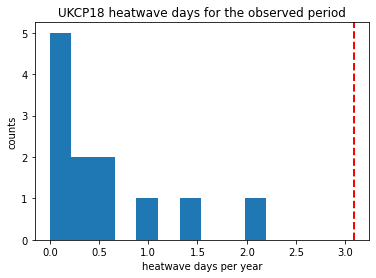

In [6]:
plt.hist(days)
plt.axvline(x=days_obv, color='r', linestyle='dashed', linewidth=2)
plt.title('UKCP18 heatwave days for the observed period')
plt.xlabel('heatwave days per year')
plt.ylabel('counts')
plt.show()

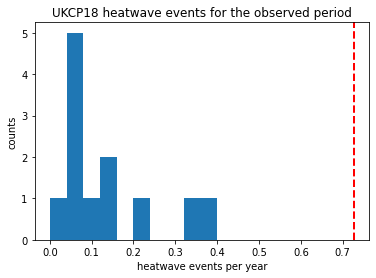

In [7]:
plt.hist(events)
plt.axvline(x=events_obv, color='r', linestyle='dashed', linewidth=2)
plt.title('UKCP18 heatwave events for the observed period')
plt.xlabel('heatwave events per year')
plt.ylabel('counts')
plt.show()

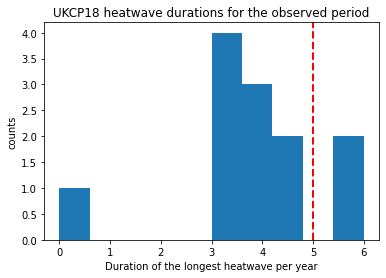

In [8]:
plt.hist(duration)
plt.axvline(x=duration_obv, color='r', linestyle='dashed', linewidth=2)
plt.title('UKCP18 heatwave durations for the observed period')
plt.xlabel('Duration of the longest heatwave per year')
plt.ylabel('counts')
plt.show()

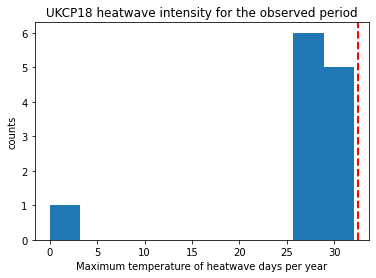

In [77]:
plt.hist(intensity)
plt.axvline(x=intensity_obv, color='r', linestyle='dashed', linewidth=2)
plt.title('UKCP18 heatwave intensity for the observed period')
plt.xlabel('Maximum temperature of heatwave days per year')
plt.ylabel('counts')
plt.show()

**Conclusion:** The UKCP18 data captures some heatwave events but the observation falls outside of the modelled data. This suggests any heatwave attributes in the future weather will be conservative.

## How do the heatwave parameters change under climate change

The four heatwave parameters considered are: days, events, duration and intensity. I wish to compare the values of each for the current and future model output. I will also compare these changes to the changes projected by Perkins-Kirkpatrick.



#### Comparing past and future modeled data.

In [12]:
column_names = ['model_run', 'year', 'location', 'hw_days', 'hw_events', 'hw_duration', 'hw_intensity']
df_att = pd.DataFrame(columns = column_names)

In [16]:
k = 0
filenames = listdir('./UKCP18/tasmax/')
for filename in filenames:
    df = pd.read_csv('./UKCP18/tasmax/'+filename)
    columns = df.columns.tolist()
    for column in columns:
        ## Extract the heatwaves
        df['thresh' + column] = np.where(df[column] >= 28, 1,0)
        # where it is either the first day of a heatwave or part of a heatwave
        length = len(df[column])
        array = np.zeros(length)
        for i in range(length):
            if sum(df['thresh' + column][i:i+3]) == 3:
                array[i] = 1
            elif df['thresh' + column][i] == 1 and array[i-1] ==1:
                array[i] = 1
        df['HW' + column] = array
        ## Extract attributes - number of heatwave days, number of events, peak temperature, duration of longest heatwave
        hw_days = sum(array)
        hw_events = 0
        hw_duration = 0
        hw_intensity = 0
        for i in range(len(array)):
            counter = 0
            if array[i] == 1 and array[i-1] == 0:
                hw_events = hw_events + 1
                value = 1
                j = i
                while value == 1:
                    counter = counter + 1
                    value = array[j]
                    j = j + 1
                if counter > hw_duration:
                    hw_duration = counter - 1
            if array[i] == 1:
                temp = df[column][i]
                if temp > hw_intensity:
                    hw_intensity = round(temp, 2)
        row = [filename[31:33], filename[38:42], column, hw_days, hw_events, hw_duration, hw_intensity]
        df_att.loc[k] = row
        k = k+1
        
df_att_fut = tuple(df_att.groupby('location'))
df_att_fut = df_att_fut[2][1]
df_att_obv = tuple(df_att_mod.groupby('location'))
df_att_obv = df_att_obv[2][1]

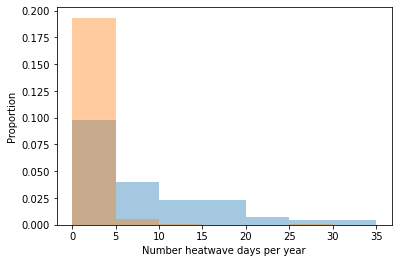

In [67]:
fig, ax = plt.subplots()
sns.distplot(df_att_fut['hw_days'], bins=range(0, 40, 5), ax=ax, kde = False, norm_hist=True)
sns.distplot(df_att_obv['hw_days'], bins=range(0, 40, 5), ax=ax, kde = False, norm_hist=True)
plt.xlabel('Number heatwave days per year')
plt.ylabel('Proportion')
plt.show()

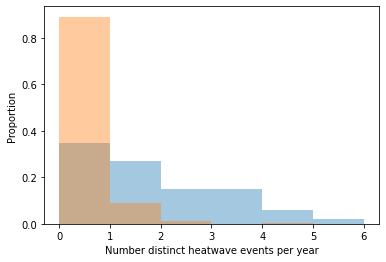

In [68]:
fig, ax = plt.subplots()
sns.distplot(df_att_fut['hw_events'], bins=range(0, 7, 1), ax=ax, kde = False, norm_hist=True)
sns.distplot(df_att_obv['hw_events'], bins=range(0, 7, 1), ax=ax, kde = False, norm_hist=True)
plt.xlabel('Number distinct heatwave events per year')
plt.ylabel('Proportion')
plt.show()

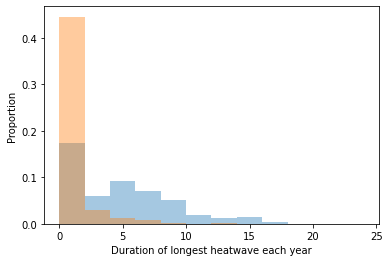

In [79]:
fig, ax = plt.subplots()
sns.distplot(df_att_fut['hw_duration'], bins=range(0, 25, 2), ax=ax, kde = False, norm_hist=True)
sns.distplot(df_att_obv['hw_duration'], bins=range(0, 25, 2), ax=ax, kde = False, norm_hist=True)
plt.xlabel('Duration of longest heatwave each year')
plt.ylabel('Proportion')
plt.show()

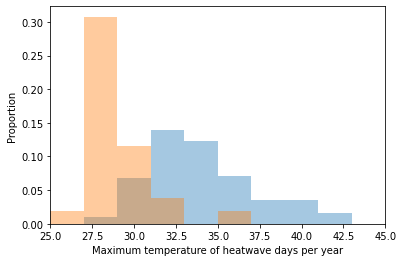

In [82]:
fig, ax = plt.subplots()
sns.distplot(df_att_fut['hw_intensity'], bins=range(25, 45, 2), ax=ax, kde = False, norm_hist=True)
sns.distplot(df_att_obv['hw_intensity'], bins=range(25, 45, 2), ax=ax, kde = False, norm_hist=True)
ax.set_xlim([25, 45])
plt.xlabel('Maximum temperature of heatwave days per year')
plt.ylabel('Proportion')
plt.show()

#### Comparison to Perkins-Kirkpatrick

In [107]:
days_obv = df_att_obv['hw_days'].mean()
events_obv = df_att_obv['hw_events'].mean()
x = (df_att_obv['hw_duration'].replace(0, np.NaN)).to_numpy()
duration_obv = np.nanmean(x)
x = (df_att_obv['hw_intensity'].replace(0, np.NaN)).to_numpy()
intensity_obv = np.nanmean(x)

means = [days_obv, events_obv, duration_obv, intensity_obv]

In [455]:
grouped = tuple(df_att_fut.groupby('model_run'))

days_fut = np.zeros(12)
events_fut = np.zeros(12)
duration_fut = np.zeros(12)
intensity_fut = np.zeros(12)

for model_run in range(12):
    days_fut[model_run] = grouped[model_run][1]['hw_days'].mean()
    events_fut[model_run] = grouped[model_run][1]['hw_events'].mean()
    x = (grouped[model_run][1]['hw_duration'].replace(0, np.NaN)).to_numpy()
    duration_fut[model_run] = np.nanmean(x)
    x = (grouped[model_run][1]['hw_intensity'].replace(0, np.NaN)).to_numpy()
    intensity_fut[model_run] = np.nanmean(x)

In [108]:
par1 = np.array([16.1, 7.4, 25.1])
par2 = np.array([1.3, 0.3, 2.2])
par3 = np.array([4.2, 1.9, 13])
par4 = np.array([1.5, 0.6, 2.4])

days_proj = means[0] + par1*2
print('Projected heatwave days: ', round(days_proj[0],1), '(', round(days_proj[1],1), ', ', round(days_proj[2], 1), ')')
events_proj = means[1] + par2*2
print('Projected heatwave events: ', round(events_proj[0],1), '(', round(events_proj[1],1), ', ', round(events_proj[2], 1), ')')
dur_proj = means[2] + par3*2
print('Projected heatwave duration: ', round(dur_proj[0],1), '(', round(dur_proj[1],1), ', ', round(dur_proj[2], 1), ')')
int_proj = means[3] + par4*2
print('Projected heatwave intensity: ', round(int_proj[0],1), '(', round(int_proj[1],1), ', ', round(int_proj[2], 1), ')')

Projected heatwave days:  32.8 ( 15.4 ,  50.8 )
Projected heatwave events:  2.7 ( 0.7 ,  4.5 )
Projected heatwave duration:  12.7 ( 8.1 ,  30.3 )
Projected heatwave intensity:  31.9 ( 30.1 ,  33.7 )


In [464]:
print('Modelled heatwave attributes:')
print('heatwave days: ', round(np.median(days_fut), 1), '(', np.quantile(days_fut, .05), ',', np.quantile(days_fut, .95), ')')
print('heatwave events: ', round(np.median(events_fut), 1), '(', np.quantile(events_fut, .05), ',', np.quantile(events_fut, .95), ')')
print('heatwave duration: ', round(np.nanmedian(duration_fut), 1), '(', np.quantile(duration_fut, .05), ',', np.quantile(duration_fut, .95), ')')
print('heatwave intensity: ', round(np.nanmedian(intensity_fut), 1), '(', np.quantile(intensity_fut, .05), ',', np.quantile(intensity_fut, .95), ')')

Modelled heatwave attributes:
heatwave days:  7.3 ( 3.2 , 13.075 )
heatwave events:  1.2 ( 0.725 , 2.3474999999999997 )
heatwave duration:  6.6 ( 4.8125 , 8.115384615384615 )
heatwave intensity:  34.0 ( 32.47694230769231 , 35.564296380090504 )


Different heatwave definitions likely need different parameter values. Perkins-Kirkpartrick lower threshold values would cause more days to be included in heatwaves with these days having lower intensities causing the discrepancies here. 

The UKCP18 data is able to capture some changes to extremes.

## Heat events in different weather files

I have TMYs, DSYs and probabalistic design weather years for London in addition to my new years. Is there different information here? In particular are there more extremes?

I'm thinking boxplots of the attributes for my years with the attributes for the design weather plotted.

In [442]:
grouped = tuple(df_att_mod.groupby('location'))
grouped = tuple(grouped[2][1].groupby('model_run'))

days_obv = np.zeros(12)
events_obv = np.zeros(12)
duration_obv = np.zeros(12)
intensity_obv = np.zeros(12)

for model_run in range(12):
    days_obv[model_run] = grouped[model_run][1]['hw_days'].max()
    events_obv[model_run] = grouped[model_run][1]['hw_events'].max()
    x = (grouped[model_run][1]['hw_duration'].replace(0, np.NaN)).to_numpy()
    duration_obv[model_run] = np.nanmax(x)
    x = (grouped[model_run][1]['hw_intensity'].replace(0, np.NaN)).to_numpy()
    intensity_obv[model_run] = np.nanmax(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: All-NaN slice encountered
  from ipykernel import kernelapp as app


#### DSY

In [443]:
columns = ['temp', 'thresh', 'HW']
df_temp = pd.DataFrame(columns=columns)

df = pd.read_csv('./existing_weatherfiles/current/London_DSY1EPW.csv')
# Extract daily maximum temperature
max_temp = np.zeros(365)
day = 0
while day < 364:
    max_temp[day] = max(df.iloc[:,3][day*24:day*24+24])
    day = day + 1
df_temp['temp'] =  max_temp
# Find heatwaves  
df_temp['thresh'] = np.where(df_temp['temp'] >= 28, 1,0) 
array = np.zeros(365)
for i in range(365):
    if sum(df_temp['thresh'][i:i+3]) == 3:
        array[i] = 1
    elif df_temp['thresh'][i] == 1 and array[i-1] == 1:
        array[i] = 1
df_temp['HW'] = array
# Calculate attributes
hw_days1 = sum(array)
hw_events1 = 0
hw_duration1 = 0
hw_intensity1 = 0
for i in range(len(array)):
    counter = 0
    if array[i] == 1 and array[i-1] == 0:
        hw_events1 = hw_events1 + 1
        value = 1
        j = i
        while value == 1:
            counter = counter + 1
            value = array[j]
            j = j + 1
        if counter > hw_duration1:
            hw_duration1 = counter - 1
    if array[i] == 1:
        temp = df_temp['temp'][i]
        if temp > hw_intensity1:
            hw_intensity1 = round(temp, 2)
            
            
df_temp = pd.DataFrame(columns=columns)

df = pd.read_csv('./existing_weatherfiles/current/London_DSY2EPW.csv')
# Extract daily maximum temperature
max_temp = np.zeros(365)
day = 0
while day < 364:
    max_temp[day] = max(df.iloc[:,3][day*24:day*24+24])
    day = day + 1
df_temp['temp'] =  max_temp
# Find heatwaves  
df_temp['thresh'] = np.where(df_temp['temp'] >= 28, 1,0) 
array = np.zeros(365)
for i in range(365):
    if sum(df_temp['thresh'][i:i+3]) == 3:
        array[i] = 1
    elif df_temp['thresh'][i] == 1 and array[i-1] == 1:
        array[i] = 1
df_temp['HW'] = array
# Calculate attributes
hw_days2 = sum(array)
hw_events2 = 0
hw_duration2 = 0
hw_intensity2 = 0
for i in range(len(array)):
    counter = 0
    if array[i] == 1 and array[i-1] == 0:
        hw_events2 = hw_events2 + 1
        value = 1
        j = i
        while value == 1:
            counter = counter + 1
            value = array[j]
            j = j + 1
        if counter > hw_duration2:
            hw_duration2 = counter - 1
    if array[i] == 1:
        temp = df_temp['temp'][i]
        if temp > hw_intensity2:
            hw_intensity2 = round(temp, 2)
            

df_temp = pd.DataFrame(columns=columns)

df = pd.read_csv('./existing_weatherfiles/current/London_DSY3EPW.csv')
# Extract daily maximum temperature
max_temp = np.zeros(365)
day = 0
while day < 364:
    max_temp[day] = max(df.iloc[:,3][day*24:day*24+24])
    day = day + 1
df_temp['temp'] =  max_temp
# Find heatwaves  
df_temp['thresh'] = np.where(df_temp['temp'] >= 28, 1,0) 
array = np.zeros(365)
for i in range(365):
    if sum(df_temp['thresh'][i:i+3]) == 3:
        array[i] = 1
    elif df_temp['thresh'][i] == 1 and array[i-1] == 1:
        array[i] = 1
df_temp['HW'] = array
# Calculate attributes
hw_days3 = sum(array)
hw_events3 = 0
hw_duration3 = 0
hw_intensity3 = 0
for i in range(len(array)):
    counter = 0
    if array[i] == 1 and array[i-1] == 0:
        hw_events3 = hw_events3 + 1
        value = 1
        j = i
        while value == 1:
            counter = counter + 1
            value = array[j]
            j = j + 1
        if counter > hw_duration3:
            hw_duration3 = counter - 1
    if array[i] == 1:
        temp = df_temp['temp'][i]
        if temp > hw_intensity3:
            hw_intensity3 = round(temp, 2)

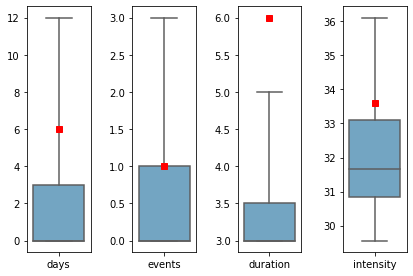

In [444]:
fig, axs = plt.subplots(1, 4)
plt.tight_layout()

sns.boxplot(x = np.full(len(days_obv), 'days'), y = days_obv, ax = axs[0], palette='PuBuGn', whis = 100)
axs[0].plot(0, hw_days1, 'rs')
#axs[0].plot(0, hw_days2, 'go')
#axs[0].plot(0, hw_days3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'events'), y = events_obv, ax = axs[1], palette='PuBuGn', whis = 100)
axs[1].plot(0, hw_events1, 'rs')
#axs[1].plot(0.05, hw_events2, 'go')
#axs[1].plot(0, hw_events3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'duration'), y = duration_obv, ax = axs[2], palette='PuBuGn', whis = 100)
axs[2].plot(0, hw_duration1, 'rs')
#axs[2].plot(0, hw_duration2, 'go')
#axs[2].plot(0, hw_duration3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'intensity'), y = intensity_obv, ax = axs[3], palette='PuBuGn', whis = 100)
axs[3].plot(0, hw_intensity1, 'rs')
#axs[3].plot(0, hw_intensity2, 'go')
#axs[3].plot(0, hw_intensity3, 'yp')

plt.show()

#### TMY

In [445]:
columns = ['temp', 'thresh', 'HW']
df_temp = pd.DataFrame(columns=columns)

df = pd.read_csv('./existing_weatherfiles/current/GBR_London.Gatwick.037760_IWECEPW.csv')
# Extract daily maximum temperature
max_temp = np.zeros(365)
day = 0
while day < 364:
    max_temp[day] = max(df.iloc[:,3][day*24:day*24+24])
    day = day + 1
df_temp['temp'] =  max_temp
# Find heatwaves  
df_temp['thresh'] = np.where(df_temp['temp'] >= 28, 1,0) 
array = np.zeros(365)
for i in range(365):
    if sum(df_temp['thresh'][i:i+3]) == 3:
        array[i] = 1
    elif df_temp['thresh'][i] == 1 and array[i-1] == 1:
        array[i] = 1
df_temp['HW'] = array
# Calculate attributes
hw_days = sum(array)
hw_events = 0
hw_duration = 0
hw_intensity = 0
for i in range(len(array)):
    counter = 0
    if array[i] == 1 and array[i-1] == 0:
        hw_events = hw_events + 1
        value = 1
        j = i
        while value == 1:
            counter = counter + 1
            value = array[j]
            j = j + 1
        if counter > hw_duration:
            hw_duration = counter - 1
    if array[i] == 1:
        temp = df_temp['temp'][i]
        if temp > hw_intensity:
            hw_intensity = round(temp, 2)

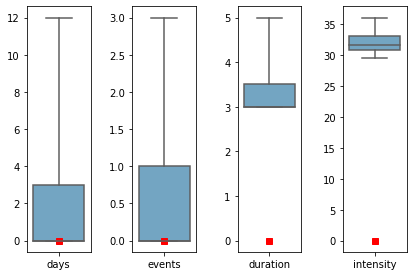

In [446]:
fig, axs = plt.subplots(1, 4)
plt.tight_layout()

sns.boxplot(x = np.full(len(days_obv), 'days'), y = days_obv, ax = axs[0], palette='PuBuGn', whis = 100)
axs[0].plot(0, hw_days, 'rs')

sns.boxplot(x = np.full(len(days_obv), 'events'), y = events_obv, ax = axs[1], palette='PuBuGn', whis = 100)
axs[1].plot(0, hw_events, 'rs')

sns.boxplot(x = np.full(len(days_obv), 'duration'), y = duration_obv, ax = axs[2], palette='PuBuGn', whis = 100)
axs[2].plot(0, hw_duration, 'rs')

sns.boxplot(x = np.full(len(days_obv), 'intensity'), y = intensity_obv, ax = axs[3], palette='PuBuGn', whis = 100)
axs[3].plot(0, hw_intensity, 'rs')

plt.show()

#### Morphed DSY

In [447]:
grouped = tuple(df_att_fut.groupby('model_run'))

days_fut = np.zeros(12)
events_fut = np.zeros(12)
duration_fut = np.zeros(12)
intensity_fut = np.zeros(12)

for model_run in range(12):
    days_fut[model_run] = grouped[model_run][1]['hw_days'].max()
    events_fut[model_run] = grouped[model_run][1]['hw_events'].max()
    x = (grouped[model_run][1]['hw_duration'].replace(0, np.NaN)).to_numpy()
    duration_fut[model_run] = np.nanmax(x)
    x = (grouped[model_run][1]['hw_intensity'].replace(0, np.NaN)).to_numpy()
    intensity_fut[model_run] = np.nanmax(x)

In [448]:
columns = ['temp', 'thresh', 'HW']
df_temp = pd.DataFrame(columns=columns)

df = pd.read_csv('./existing_weatherfiles/future/London_DSY1_85_2065_50EPW.csv')
# Extract daily maximum temperature
max_temp = np.zeros(365)
day = 0
while day < 364:
    max_temp[day] = max(df.iloc[:,3][day*24:day*24+24])
    day = day + 1
df_temp['temp'] =  max_temp
# Find heatwaves  
df_temp['thresh'] = np.where(df_temp['temp'] >= 28, 1,0) 
array = np.zeros(365)
for i in range(365):
    if sum(df_temp['thresh'][i:i+3]) == 3:
        array[i] = 1
    elif df_temp['thresh'][i] == 1 and array[i-1] == 1:
        array[i] = 1
df_temp['HW'] = array
# Calculate attributes
hw_days1 = sum(array)
hw_events1 = 0
hw_duration1 = 0
hw_intensity1 = 0
for i in range(len(array)):
    counter = 0
    if array[i] == 1 and array[i-1] == 0:
        hw_events1 = hw_events1 + 1
        value = 1
        j = i
        while value == 1:
            counter = counter + 1
            value = array[j]
            j = j + 1
        if counter > hw_duration1:
            hw_duration1 = counter - 1
    if array[i] == 1:
        temp = df_temp['temp'][i]
        if temp > hw_intensity1:
            hw_intensity1 = round(temp, 2)


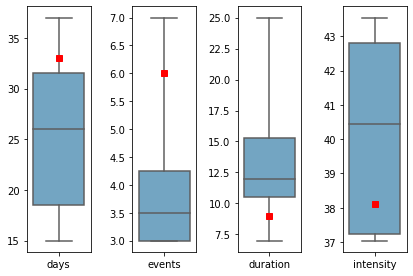

In [450]:
fig, axs = plt.subplots(1, 4)
plt.tight_layout()

sns.boxplot(x = np.full(len(days_obv), 'days'), y = days_fut, ax = axs[0], palette='PuBuGn', whis = 100)
axs[0].plot(0, hw_days1, 'rs')
#axs[0].plot(0, hw_days2, 'go')
#axs[0].plot(0, hw_days3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'events'), y = events_fut, ax = axs[1], palette='PuBuGn', whis = 100)
axs[1].plot(0, hw_events1, 'rs')
#axs[1].plot(0.05, hw_events2, 'go')
#axs[1].plot(0, hw_events3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'duration'), y = duration_fut, ax = axs[2], palette='PuBuGn', whis = 100)
axs[2].plot(0, hw_duration1, 'rs')
#axs[2].plot(0, hw_duration2, 'go')
#axs[2].plot(0, hw_duration3, 'yp')

sns.boxplot(x = np.full(len(days_obv), 'intensity'), y = intensity_fut, ax = axs[3], palette='PuBuGn', whis = 100)
axs[3].plot(0, hw_intensity1, 'rs')
#axs[3].plot(0, hw_intensity2, 'go')
#axs[3].plot(0, hw_intensity3, 'yp')

plt.show()

Longer more intense events exist within the model distribution.

## Heat events under different metrics

Do my metrics correlate better with observed excess deaths during past heat events?

CIBSE define overheating as: 'conditions when the comfortable internal temperature threshold of 28°C is surpassed for over 1% of the time.' 

Using 28°C as a threshold gives a correlation coefficient with excess deaths of 0.5376 (significant at the 5% level) but weaker than any of the new metrics.